# Predicting Price with Size, Location, and Neighborhood

Our Goal

1> Build a model to predict appartment prices

2> Evaluate features in our dataset

3> Two Deployments of our trained model


In [41]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

In [69]:
# Wrangle Function ( Our Old but Gold )

def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # Drop features with high null percentage
    df.drop(columns = ["floor", "expenses"], inplace =True )

    # Drop low- and high- cardinality categorical variable
    df.drop(columns=["operation","property_type", "currency", "properati_url"], inplace =True)

    # Drop leaky features

    df.drop(columns=(["price","price_aprox_local_currency","price_per_m2","price_usd_per_m2"]), inplace=True)
    
    # droping out our multicollinearity coloumns
    df.drop(columns=(["surface_total_in_m2","rooms"]),inplace=True)  

    return df

In [70]:
# Extract all file paths 

files =  glob("C:\\Users\\ujjwa\\Desktop\Hackathons and Challenges\\Buenos-aries-real-estate\\buenos-airies-real-estate-*.csv")
files

['C:\\Users\\ujjwa\\Desktop\\Hackathons and Challenges\\Buenos-aries-real-estate\\buenos-airies-real-estate-1.csv',
 'C:\\Users\\ujjwa\\Desktop\\Hackathons and Challenges\\Buenos-aries-real-estate\\buenos-airies-real-estate-2.csv',
 'C:\\Users\\ujjwa\\Desktop\\Hackathons and Challenges\\Buenos-aries-real-estate\\buenos-airies-real-estate-3.csv',
 'C:\\Users\\ujjwa\\Desktop\\Hackathons and Challenges\\Buenos-aries-real-estate\\buenos-airies-real-estate-4.csv',
 'C:\\Users\\ujjwa\\Desktop\\Hackathons and Challenges\\Buenos-aries-real-estate\\buenos-airies-real-estate-5.csv']

In [71]:
# Storing it in a single frame using file comprehension

frames = [wrangle(file) for file in files ]

# check for different values
type(frames)
len(frames)
type(frames[0])
frames[0].head()

# concat it into single frame
df = pd.concat(frames, ignore_index= True)



# More Compact code
# pd.concat([wrangle(file) for file in files ], ignore_index= True)

In [72]:
# check for new data frame

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


# Exploratory Data Analysis 



In [73]:
# Operating Missing values

# after getting insights of data "floor"  and "expense" have ton of null values


df.isnull().sum()/len(df) # finding null values percentage.

# if values are more than 50 % null then we simply drop those coloumns ..
# lets update our coloumns to remove floor and expense coloumns




price_aprox_usd          0.000000
surface_covered_in_m2    0.000000
lat                      0.040413
lon                      0.040413
neighborhood             0.000000
dtype: float64

In [74]:
# Low and High Cardinality categorical variable

# First task  -> collect all categorical variables in our data frame

df.select_dtypes("object").head()

#checking for unique values 

df.select_dtypes("object").nunique()

# In property and operation type there are operation and property_type (these are low cardinality variables)

# Basically all these non unique will not contribut in feature matrix , lets think of hthe case what will amodel distinguish between all apartments nothing .....
# It remains same for both highly expensive and low expensive houses
# While there are a high cardinality variable (which is properati_url) , it will also not benificial as it leads to case of curse dimensonality .... (not preferable )


neighborhood    57
dtype: int64

In [ ]:
# In Simple terms 
#  Low cardinality refers to " no information "
#  High cardinality refers to " information overload "


#  Finally we came up with conclusion that out of the 5 features(operation, property_type, currency, properati_url, neighborhood) only neighborhood is used for further computation all other will discarded
df.drop(columns=["operation","property_type", "currency", "properati_url"], inplace =True) # update this in wrangle function


In [39]:
# Leakage

# It's also important for us to drop any columns that would constitute leakage, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed.

# Check for leakage variables

sorted(df.columns)

# Price , price_aprox_local_currency , price_per_m2 , price_usd_per_m2 these are leakage as they are helping (say cheating )with model to leakeage condition
df.drop(columns=(["price","price_aprox_local_currency","price_per_m2","price_usd_per_m2"]),inplace=True)
# Update our Wrangle function to remove leaky coloumn

['lat',
 'lon',
 'neighborhood',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

In [76]:
# Multi Collinearity

# What is Correlation?

    # Relation between Two variables
    # eg price with area

# What is MultiCollinearity?
    # if two features both are highly correlated came upto same feature matix

# What is the problem with this ??
#  If you are worried with model intrepretaion capablity then u have to worried otherwise it is not a problem 
#  Suppose you have two highly correlated features , then  it will came up with cofficients you can never be rely faith , it ruins the interpretablity power of model...

# Creating heatmap 

# creating correlation matrix
corr = df.select_dtypes('number').drop(columns = "price_aprox_usd").corr()
corr


,surface_covered_in_m2,lat,lon
surface_covered_in_m2,1.000000,0.028538,0.034515
lat,0.028538,1.000000,-0.262439
lon,0.034515,-0.262439,1.000000


<AxesSubplot: >

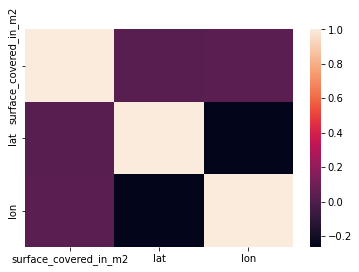

In [77]:
# Using seaborn to implement heatmap
sns.heatmap(corr)

In [57]:
# More interpretation
df.info() # surface_total_in_m2 and rooms both have null values its better to drop them and wor on only single unit which is surface_covered_in_m2 

df.drop(columns=["surface_total_in_m2","rooms"],inplace=True) # Update our wrangle ..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_total_in_m2    4752 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   rooms                  5286 non-null   float64
 4   lat                    6316 non-null   float64
 5   lon                    6316 non-null   float64
 6   neighborhood           6582 non-null   object 
dtypes: float64(6), object(1)
memory usage: 360.1+ KB


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


In [80]:
# Split Data 

target = "price_aprox_usd"
features = ["surface_covered_in_m2","lat","lon","neighborhood"]
y_train =df[target]
X_train =df[features]


In [87]:
# Find mean
y_mean =y_train.mean()

# Setting baseline
y_pred_baseline = [y_mean] * len(y_train)

print("Mean apt price:", round(y_mean,2))

print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))



Mean apt price: 132383.84
Baseline MAE: 44860.10834274133


In [90]:
# creating model

model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [91]:
# Model Evaluation

y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 24207.11


In [100]:
# Predicting Values

X_test = wrangle("C:\\Users\\ujjwa\\Desktop\\Hackathons and Challenges\\Buenos-aries-real-estate\\housing-in-buenos-aires_data_buenos-aires-test-features.csv")
X_test.drop(columns=["price_aprox_usd"],inplace=True)
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    131380.285973
1    253288.977975
2     64645.451113
3    117220.512743
4     81040.717816
dtype: float64

In [108]:
X_train.head()

,surface_covered_in_m2,lat,lon,neighborhood
0,70.0,-34.584651,-58.454693,Chacarita
1,42.0,-34.638979,-58.500115,Villa Luro
2,54.0,-34.615847,-58.459957,Caballito
3,42.0,-34.625222,-58.382382,Constitución
4,50.0,-34.610610,-58.412511,Once


In [112]:
# Creating Prediction Function

def make_prediction(area, lat, lon,  neighborhood  ):
    # converting given input into dataframe
    data ={
        "surface_covered_in_m2":area,
        "lat":lat,
        "lon":lon,
        "neighborhood":neighborhood
        }
    df =pd.DataFrame(data, index=[0])

    # model fit dataframe
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [113]:
# Try Case

make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

In [114]:
# Interactive Dashboard

interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…